

---



---

## **PIPELINE INITIAL (référentiel R calculé avec érosion simple)**

---



---





---

# 1. Chargement de l'image et inversion

---



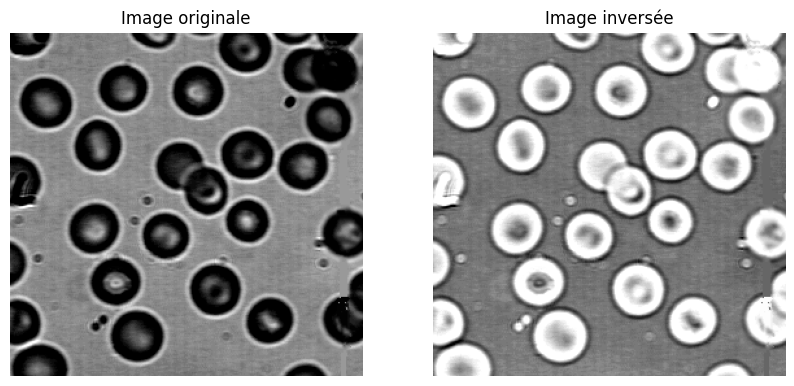

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.filters import threshold_otsu

# Étape 1 : Charger l'image en niveaux de gris (BLOOD1.TIF)
# Nous utilisons 'as_gray=True' pour garantir une image en niveaux de gris.
image = io.imread('BLOOD1.TIF', as_gray=True)

# Étape 2 : Inverser l'image (les cellules sanguines deviennent blanches)
# On inverse l'image car les cellules sanguines sont naturellement plus foncées.
inverted_image = np.invert(image)

# Affichage des images originales et inversées pour inspection.
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Image originale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(inverted_image, cmap='gray')
plt.title("Image inversée")
plt.axis('off')
plt.show()




---

# 2. Binarisation et éléments structurants pour érosion

---



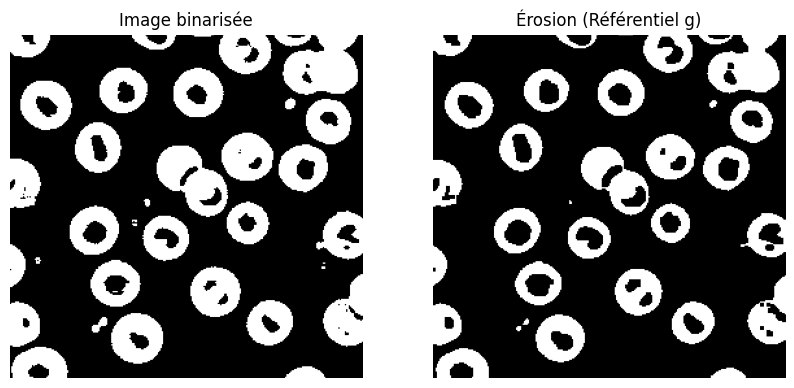

In [2]:
from skimage import morphology

# Étape 3 : Binariser l'image inversée à l'aide de la méthode d'Otsu
# La méthode d'Otsu est utilisée pour trouver le seuil optimal de binarisation.
thresh = threshold_otsu(inverted_image)
binary_image = inverted_image > thresh

# Étape 4 : Tester différents éléments structurants pour érosion
# On utilise différents éléments structurants (disque, carré, croix) pour l'érosion.
structuring_element = morphology.disk(radius=1)
referential_g_disk = morphology.erosion(binary_image, morphology.disk(1))
referential_g_square = morphology.erosion(binary_image, morphology.square(3))
referential_g_cross = morphology.erosion(binary_image, morphology.diamond(1))

# Sélectionner le référentiel 'g' souhaité
referential_g = referential_g_square  # Ici on peut essayer disk/cross pour comparaison

# Affichage de l'image binarisée et de l'érosion
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap='gray')
plt.title("Image binarisée")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(referential_g, cmap='gray')
plt.title("Érosion (Référentiel g)")
plt.axis('off')
plt.show()



---

# 3. Reconstruction géodésique avec itérations contrôlées

---



In [3]:
# Étape 6 : Initialiser le marqueur pour la reconstruction avec l'image binaire
# Le marqueur initial est une matrice vide du même format que l'image binaire.
marker = np.zeros_like(binary_image, dtype=bool)

# Paramètres pour le critère d'arrêt
max_iterations = 100  # Limite d'itérations pour éviter les boucles infinies
change_threshold = 1e-5  # Seuil de changement pour l'arrêt de la reconstruction

# Liste pour stocker les résultats des itérations
results = []
n_iterations = 0
previous_reconstruction = marker.copy()

# Boucle d'itérations pour la reconstruction géodésique
while n_iterations < max_iterations:
    # Étape 7 : Dilatation de l'image binaire
    dilated_binary = morphology.dilation(binary_image, footprint=structuring_element)

    # Intersection avec le référentiel 'g'
    marker = np.logical_and(referential_g, dilated_binary)

    # Étape 8 : Reconstruction géodésique par dilatation
    reconstructed = morphology.reconstruction(marker, binary_image, method='dilation')

    # Calcul de la différence avec l'itération précédente
    change = np.mean(np.abs(reconstructed.astype(float) - previous_reconstruction.astype(float)))

    # Critère d'arrêt basé sur le changement entre itérations
    if change < change_threshold:
        print(f"Convergence atteinte à l'itération {n_iterations} avec un changement de {change:.6f}.")
        results.append(reconstructed)
        break

    # Mise à jour pour la prochaine itération
    previous_reconstruction = reconstructed
    results.append(reconstructed)
    n_iterations += 1

# Si on atteint le nombre maximal d'itérations sans convergence
if n_iterations >= max_iterations:
    print(f"Nombre maximal d'itérations atteint ({max_iterations}). Dernier changement : {change:.6f}.")


Convergence atteinte à l'itération 1 avec un changement de 0.000000.




---

# 4. Affichage des résultats

---



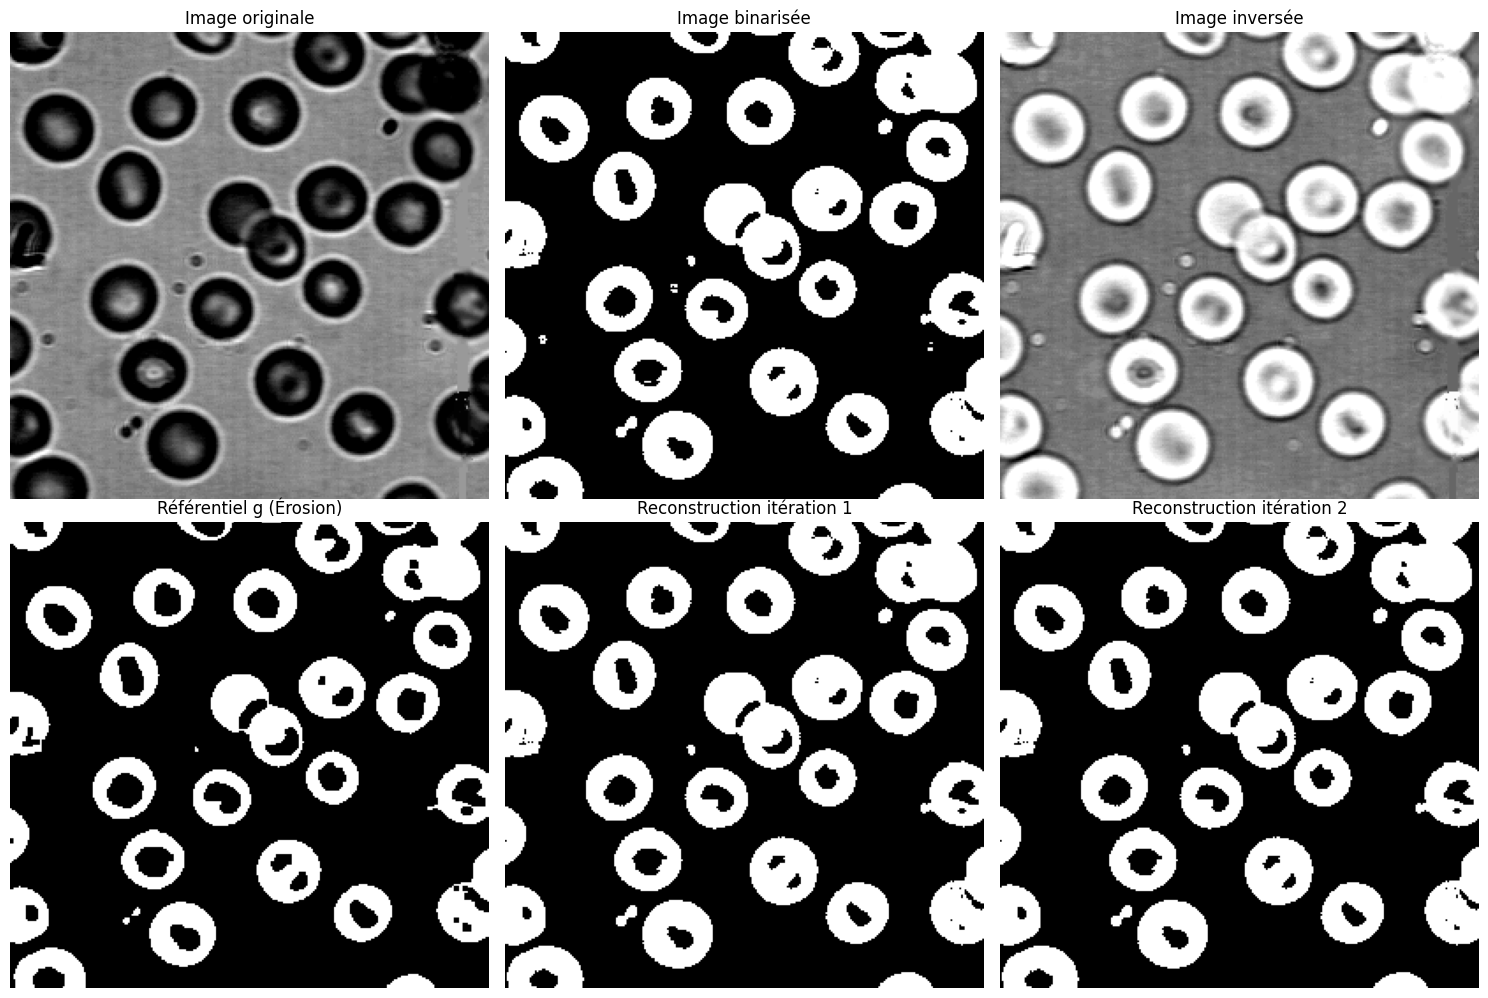

In [4]:
# Affichage des résultats de reconstruction
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Image originale
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Image originale")
axes[0, 0].axis('off')

# Image binarisée
axes[0, 1].imshow(binary_image, cmap='gray')
axes[0, 1].set_title("Image binarisée")
axes[0, 1].axis('off')

# Image inversée
axes[0, 2].imshow(inverted_image, cmap='gray')
axes[0, 2].set_title("Image inversée")
axes[0, 2].axis('off')

# Image érodée (référentiel g)
axes[1, 0].imshow(referential_g, cmap='gray')
axes[1, 0].set_title("Référentiel g (Érosion)")
axes[1, 0].axis('off')

# Résultats de chaque itération de la reconstruction
for i in range(min(len(results), 3)):  # Limiter à 3 itérations pour l'affichage
    axes[1, i + 1].imshow(results[i], cmap='gray')
    axes[1, i + 1].set_title(f"Reconstruction itération {i + 1}")
    axes[1, i + 1].axis('off')

plt.tight_layout()
plt.show()




---



---

## **PIPELINE EN VARIANT LE REFERENTIEL R ET OPTIMISANT LE SE (élément Structurant) (utilisation d'un Filtrage Multi-niveaux (Multi-scale Filtering) et 2 autres techniques :**

## 1. **Transformation top-hat et bottom-hat** pour l'extraction des caractéristiques des cellules sanguines.
## 2. **Éléments structurants multi-échelles (multi-scale SE)** pour ajuster progressivement le contraste et capturer différents détails à plusieurs niveaux.
## 3. **Optimisation de la taille du SE** en calculant le contenu des contours (Edge Content, EC) afin de choisir la meilleure taille d'élément structurant.

---



---





---

## Imports + inversion de l'image en niveau de gris avec explication(s)

---



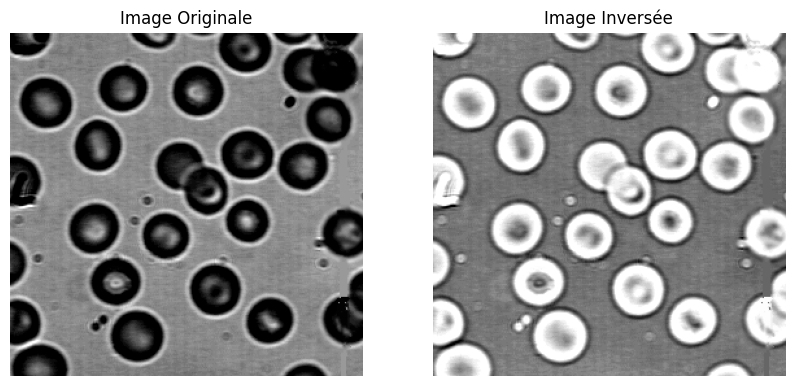

In [5]:
# 1. Chargement et inversion de l'image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, filters
from skimage.filters import threshold_otsu

# Charger l'image (BLOOD1.TIF)
image = io.imread('BLOOD1.TIF', as_gray=True)

# Inverser l'image pour que les cellules sanguines soient blanches
inverted_image = np.invert(image)

# Afficher l'image originale et inversée
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Image Originale")
axes[0].axis('off')

axes[1].imshow(inverted_image, cmap='gray')
axes[1].set_title("Image Inversée")
axes[1].axis('off')

plt.show()


### **Inversion de l'image :** L'objectif est de rendre les cellules sanguines blanches pour mieux appliquer les transformations morphologiques.



---

## **Top-hat :** Extraire les objets lumineux plus petits que l'élément structurant.
## **Bottom-hat :** Extraire les objets sombres plus petits que l'élément structurant.
## **Image améliorée :** Combinaison des deux pour améliorer le contraste global.

---



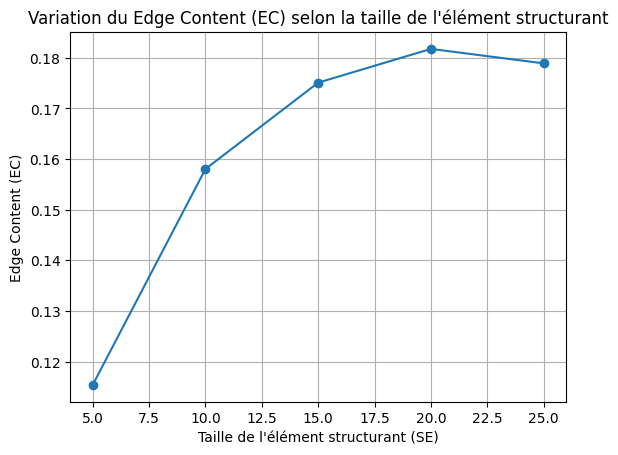

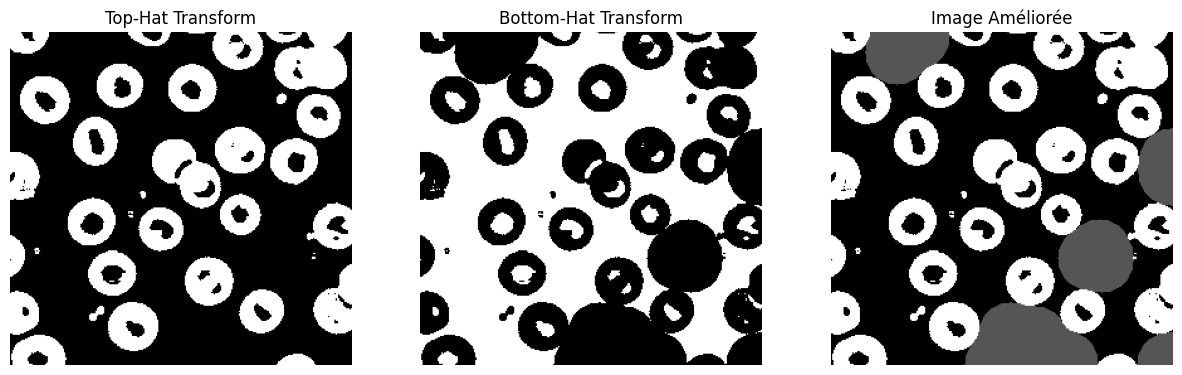

In [15]:
# 2. Binarisation (c'est fait déja) et transformation top-hat/bottom-hat/Enhance
# Fonction pour calculer le contenu des contours (Edge Content)
def edge_content(image, structuring_element):
    # Conversion de l'image booléenne en entier pour permettre le calcul du gradient
    image_int = image.astype(np.int32)

    gradient_x = np.gradient(image_int, axis=1)  # Gradient dans la direction x
    gradient_y = np.gradient(image_int, axis=0)  # Gradient dans la direction y

    # Magnitude du gradient
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    return np.mean(gradient_magnitude)

# Tester différentes tailles d'éléments structurants et calculer le contenu des contours (Edge Content, EC)
se_sizes = [5, 10, 15, 20, 25]
ec_values = []

for size in se_sizes:
    se = morphology.disk(size)
    # Conversion de l'image binaire en image entière pour éviter les erreurs lors des opérations
    binary_image_int = binary_image.astype(np.int32)

    # Application des transformations top-hat et bottom-hat
    top_hat = binary_image_int - morphology.opening(binary_image_int, se)
    bottom_hat = morphology.closing(binary_image_int, se) - binary_image_int

    # Formule complète pour l'image améliorée (A_enhance)
    enhanced_image = binary_image_int + top_hat - bottom_hat

    # Calcul du contenu des contours (Edge Content)
    ec = edge_content(enhanced_image, se)
    ec_values.append(ec)

# Afficher la variation du EC en fonction de la taille du SE
plt.plot(se_sizes, ec_values, marker='o')
plt.title('Variation du Edge Content (EC) selon la taille de l\'élément structurant')
plt.xlabel('Taille de l\'élément structurant (SE)')
plt.ylabel('Edge Content (EC)')
plt.grid(True)
plt.show()


# Afficher les transformations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(top_hat, cmap='gray')
axes[0].set_title("Top-Hat Transform")
axes[0].axis('off')

axes[1].imshow(bottom_hat, cmap='gray')
axes[1].set_title("Bottom-Hat Transform")
axes[1].axis('off')

axes[2].imshow(enhanced_image, cmap='gray')
axes[2].set_title("Image Améliorée")
axes[2].axis('off')

plt.show()




---

## **Edge Content (EC) :** Mesure de la force des contours pour différentes tailles d'éléments structurants.
## **Optimisation du SE :** La taille optimale est celle qui maximise le contenu des contours (EC).

---





---

## **Élément structurant optimal :** Celui qui maximise le contenu des contours EC.
## **Reconstruction géodésique :** On applique la reconstruction avec l'élément structurant optimal pour capturer au mieux les contours des cellules sanguines.

---



## Un size **pas necessairement optimal de B** (SE)

Convergence atteinte après 2 itérations avec une erreur de 0.00000.


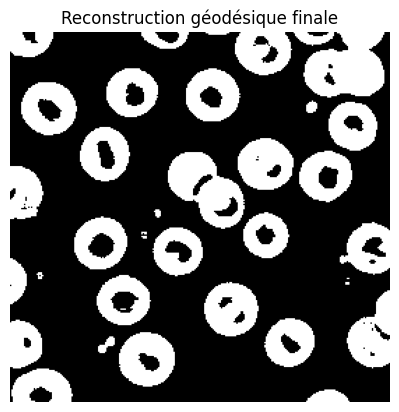

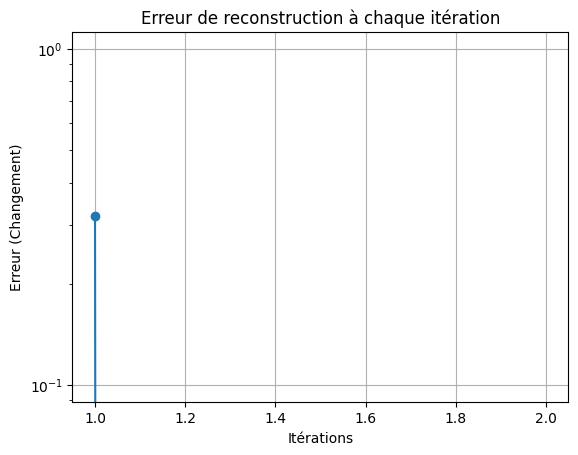

In [20]:
# 4. Reconstruction géodésique avec le SE optimal
optimal_se_size = 8 # Taille de SE déterminée précédemment
optimal_se = morphology.disk(optimal_se_size)  # Création de l'élément structurant

# Initialisation des variables pour la reconstruction
marker = np.zeros_like(binary_image, dtype=bool)  # Marqueur initial, tous les pixels sont faux
max_iterations = 100  # Nombre maximum d'itérations
change_threshold = 1e-5  # Seuil pour détecter les changements
n_iterations = 0  # Compteur d'itérations
previous_reconstruction = marker.copy()  # Reconstruction précédente
results = []  # Liste pour stocker les résultats de chaque itération
errors = []  # Liste pour stocker les erreurs à chaque itération

# Boucle de reconstruction géodésique
while n_iterations < max_iterations:
    # Dilatation de l'image binaire avec l'élément structurant
    dilated_binary = morphology.dilation(binary_image, footprint=optimal_se)
    # Application du marqueur, en ne conservant que les pixels qui sont à la fois dans binary_image et dilated_binary
    marker = np.logical_and(binary_image, dilated_binary)
    # Reconstruction géodésique en utilisant la méthode de dilatation
    reconstructed = morphology.reconstruction(marker, binary_image, method='dilation')

    # Calcul de la différence entre la reconstruction actuelle et la précédente
    change = np.mean(np.abs(reconstructed.astype(float) - previous_reconstruction.astype(float)))

    # Stockage de l'erreur
    errors.append(change)

    # Si le changement est inférieur au seuil, on sort de la boucle
    if change < change_threshold:
        print(f"Convergence atteinte après {n_iterations + 1} itérations avec une erreur de {change:.5f}.")
        break

    previous_reconstruction = reconstructed  # Mise à jour de la reconstruction précédente
    results.append(reconstructed)  # Ajout de la reconstruction actuelle à la liste
    n_iterations += 1  # Incrémentation du compteur d'itérations

# Afficher la reconstruction finale
plt.imshow(reconstructed, cmap='gray')
plt.title("Reconstruction géodésique finale")
plt.axis('off')
plt.show()

# Afficher les erreurs à chaque itération
plt.plot(range(1, len(errors) + 1), errors, marker='o')
plt.title("Erreur de reconstruction à chaque itération")
plt.xlabel("Itérations")
plt.ylabel("Erreur (Changement)")
plt.grid(True)
plt.yscale('log')  # Échelle logarithmique pour mieux visualiser les changements
plt.show()




---

## En choississant **la valeur optimale** de taille d'élément structurant (SE) B : **size = 20**

---



Convergence atteinte après 2 itérations avec une erreur de 0.00000.


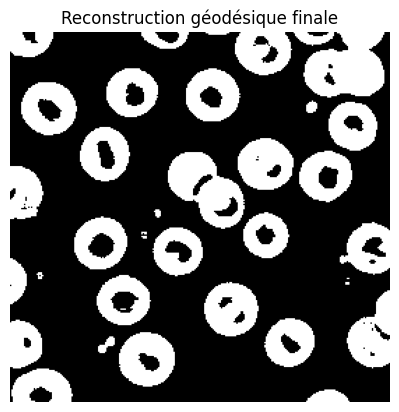

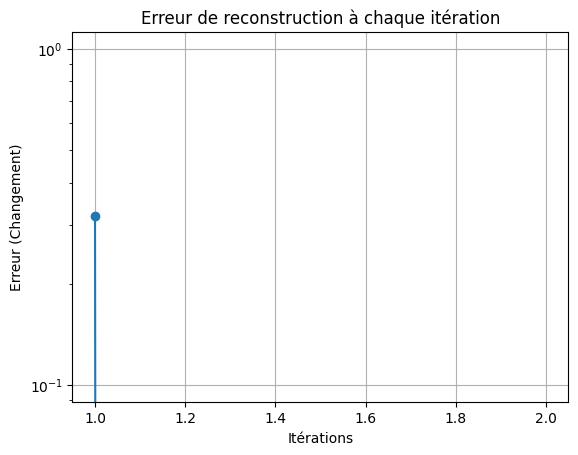

In [21]:
# 4. Reconstruction géodésique avec le SE optimal
optimal_se_size = 20  # Taille de SE déterminée précédemment
optimal_se = morphology.disk(optimal_se_size)  # Création de l'élément structurant

# Initialisation des variables pour la reconstruction
marker = np.zeros_like(binary_image, dtype=bool)  # Marqueur initial, tous les pixels sont faux
max_iterations = 100  # Nombre maximum d'itérations
change_threshold = 1e-5  # Seuil pour détecter les changements
n_iterations = 0  # Compteur d'itérations
previous_reconstruction = marker.copy()  # Reconstruction précédente
results = []  # Liste pour stocker les résultats de chaque itération
errors = []  # Liste pour stocker les erreurs à chaque itération

# Boucle de reconstruction géodésique
while n_iterations < max_iterations:
    # Dilatation de l'image binaire avec l'élément structurant
    dilated_binary = morphology.dilation(binary_image, footprint=optimal_se)
    # Application du marqueur, en ne conservant que les pixels qui sont à la fois dans binary_image et dilated_binary
    marker = np.logical_and(binary_image, dilated_binary)
    # Reconstruction géodésique en utilisant la méthode de dilatation
    reconstructed = morphology.reconstruction(marker, binary_image, method='dilation')

    # Calcul de la différence entre la reconstruction actuelle et la précédente
    change = np.mean(np.abs(reconstructed.astype(float) - previous_reconstruction.astype(float)))

    # Stockage de l'erreur
    errors.append(change)

    # Si le changement est inférieur au seuil, on sort de la boucle
    if change < change_threshold:
        print(f"Convergence atteinte après {n_iterations + 1} itérations avec une erreur de {change:.5f}.")
        break

    previous_reconstruction = reconstructed  # Mise à jour de la reconstruction précédente
    results.append(reconstructed)  # Ajout de la reconstruction actuelle à la liste
    n_iterations += 1  # Incrémentation du compteur d'itérations

# Afficher la reconstruction finale
plt.imshow(reconstructed, cmap='gray')
plt.title("Reconstruction géodésique finale")
plt.axis('off')
plt.show()

# Afficher les erreurs à chaque itération
plt.plot(range(1, len(errors) + 1), errors, marker='o')
plt.title("Erreur de reconstruction à chaque itération")
plt.xlabel("Itérations")
plt.ylabel("Erreur (Changement)")
plt.grid(True)
plt.yscale('log')  # Échelle logarithmique pour mieux visualiser les changements
plt.show()
